In [12]:
import os
from config.secret_keys import OPENAI_API_KEY, TAVILY_API_KEY

os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

# Basic LangGraph 

## State Graph 생성

- State Graph 
    - 사용자가 지정한 정보 교환 형식 (state)에 따라 정보를 주고 받는 graph
    - 이 graph에 노드를 추가해 나가면서 langgraph 프로세스를 형성한다
    - 이렇게 형성된 graph는 node 간에 사용자가 지정한 state 내에서 정보를 주고 받는다

In [1]:
from typing import TypedDict
from langgraph.graph import StateGraph

# 노드 간 주고 받을 정보의 틀(형태)를 지정하는 class
# langgraph는 state라는 형태로 노드 간 정보를 주고 받는다다
class State(TypedDict): # TypedDict : 타입 힌트를 사용하여 딕셔너리의 형태를 지정할 수 있는 클래스
    counter : int
    alphabet : list[str]

# 노드 간 정보를 주고 받을 때, 사용 자가 정의한 State라는 틀 안에서 정보를 주고 받을 수 있도록 하는 그래프
# 이렇게 생성된 StateGraph 클래스의 객체(graph_builder)는 
# State라는 형태로 노드 간 정보를 주고 받는 그래프를 만들어주는 역할을 한다
graph_builder = StateGraph(State)

## Graph 생성

In [3]:
from typing import Annotated # 어떤 값을 지정할 때, 해당 값의 meta-data를 추가할 수 있는 역할할
from typing_extensions import TypedDict # langgraph 공식 문서에서 이렇게 불러옴 (차이는 x)

from langgraph.graph import StateGraph # 
from langgraph.graph import START, END # graph의 시작 node와 끝 node
import operator

# state 정의
class State(TypedDict):
    counter : int
    alphabet : list[str]

# 노드 정의
def node_a(state: State):
    state['counter'] += 1
    state['alphabet'] = ["Hello"]

    return state

# state graph 생성
graph_builder = StateGraph(State)

# 노드 추가
graph_builder.add_node("chatbot", node_a)

# edge 연결
graph_builder.add_edge(START, "chatbot") # 단방향
graph_builder.add_edge("chatbot", END)

# graph compile
graph = graph_builder.compile()

## Graph 시각화

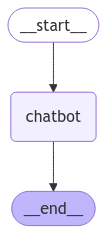

In [4]:
from IPython.display import Image, display

try :
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    pass

## Graph 실행

In [5]:
initial_state = {
    "counter" : 0,
    "alphabet" : []
}

state = initial_state

for _ in range(3):
    state = graph.invoke(state)
    print(state)

{'counter': 1, 'alphabet': ['Hello']}
{'counter': 2, 'alphabet': ['Hello']}
{'counter': 3, 'alphabet': ['Hello']}


## Node 개선
- `alphebet` 속성을 변경하며 meta-data를 추가하기
    - 해당 데이터에 대해 어떤 행동을 할 지 지정
    - ex) 이 속성에 대해 다음으로 들어오는 값을 어떻게 처리할 지

In [6]:
class State(TypedDict):
    counter : int
    alphabet : Annotated[list[str], operator.add] # Chatbot의 기억을 만들어 주는 부분 (그래프 내에서만)
    # operator.add : list[str] 형태의 값에 대해 + 연산을 수행할 수 있도록 하는 메타데이터

def node_a(state: State):
    state['counter'] += 1
    state['alphabet'] = ["Hello"]
    return state

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", node_a)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

In [7]:
initial_state = {
    "counter" : 0,
    "alphabet" : []
}

state = initial_state

for _ in range(3):
    state = graph.invoke(state)
    print(state)

{'counter': 1, 'alphabet': ['Hello']}
{'counter': 2, 'alphabet': ['Hello', 'Hello']}
{'counter': 3, 'alphabet': ['Hello', 'Hello', 'Hello']}


## Message를 담는 State Graph 만들기

In [11]:
from typing import Annotated
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages : Annotated[list, add_messages]

graph_builder = StateGraph(State)

model = ChatOpenAI(model="gpt-4o-mini")

def chatbot(state: State):
    state['messages'] = [model.invoke(state['messages'])]
    return state

graph_builder.add_node("chatbot", chatbot)

graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")

graph = graph_builder.compile()

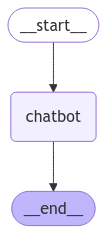

In [12]:
from IPython.display import Image, display

try :
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    pass

In [13]:
while True:
    user_input = input("User : ")
    if user_input.lower() in ['quit', 'exit', 'q']:
        print("Goodbye!")
        break
    
    for event in graph.stream({"messages" : ("user", user_input)}):
        for value in event.values():
            print("Assistant : ", value["messages"][-1].content)

Assistant :  안녕하세요! 어떻게 도와드릴까요?
Assistant :  제가 학습된 데이터는 2023년 10월까지의 정보입니다. 그 이후의 정보는 포함되어 있지 않습니다. 도움이 필요하시면 언제든지 질문해 주세요!
Goodbye!


## `MessageState`

- 메시지를 담기 위한 아래의 코드를 구현해 놓은 state class
    ```python
        class State(TypedDict):
            messages : Annotated[list, add_messages]
    ```
- 굉장히 간단한 형태의 system에서만 그대로 사용할 수 있음
- 상속을 받아서 처리하면 기존 `MessageState`의 State 형태 그대로 커스터마이징 할 수 있음

In [14]:
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState

graph_builder = StateGraph(MessagesState)

model = ChatOpenAI(model="gpt-4o-mini")

def chatbot(state: MessagesState):
    state['messages'] = [model.invoke(state['messages'])]
    return state

graph_builder.add_node("chatbot", chatbot)

graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")

graph = graph_builder.compile()

In [15]:
while True:
    user_input = input("User : ")
    if user_input.lower() in ['quit', 'exit', 'q']:
        print("Goodbye!")
        break
    
    for event in graph.stream({"messages" : ("user", user_input)}):
        for value in event.values():
            print("Assistant : ", value["messages"][-1].content)

Assistant :  안녕하세요! 어떻게 도와드릴까요?
Assistant :  현재 제가 학습된 자료의 기준일은 2023년 10월입니다. 이 이후의 정보는 포함되어 있지 않습니다. 궁금한 점이 있으시면 질문해 주세요!
Goodbye!


# LangGraph에 Tool 활용하기

## Tool 활용법 개요

In [16]:
from langchain_core.messages import AIMessage
from langchain_core.tools import tool

from langgraph.prebuilt import ToolNode

In [17]:
@tool
def get_weather(location : str):
    """Call to get the weather"""

    if location in ['서울', '인천']:
        return "It's 60 degrees and foggy"
    else :
        return "It's 90 degrees and sunny"

@tool
def get_coolest_cities():
    """Get a list of cooles cities"""
    return '서울, 고성'

In [19]:
tools = [get_weather, get_coolest_cities]
tool_node = ToolNode(tools)

In [20]:
from langchain_openai import ChatOpenAI

model_with_tools = ChatOpenAI(
    model = 'gpt-4o-mini',
    temperature=0,
).bind_tools(tools)

In [25]:
model_with_tools.invoke("서울 날씨는 어때?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0l7oVNs1S2SkDH9yzC4xQxEd', 'function': {'arguments': '{"location":"서울"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 70, 'total_tokens': 85, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0d13a334-56ac-4d98-82a4-c4939a52cbc0-0', tool_calls=[{'name': 'get_weather', 'args': {'location': '서울'}, 'id': 'call_0l7oVNs1S2SkDH9yzC4xQxEd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 70, 'output_tokens': 15, 'total_tokens': 85, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0

In [21]:
model_with_tools.invoke("서울 날씨는 어때?").tool_calls

[{'name': 'get_weather',
  'args': {'location': '서울'},
  'id': 'call_r10efQLNtmE6zPyYgbYL2Je5',
  'type': 'tool_call'}]

In [22]:
model_with_tools.invoke("한국에서 가장 추운 도시는?").tool_calls

[{'name': 'get_coolest_cities',
  'args': {},
  'id': 'call_dKyTAEo8cxSAx0N6FoQmUHBv',
  'type': 'tool_call'}]

In [24]:
# 주어진 도구로 답변을 할 수 없는 경우 tool 호출이 되지 않는 것을 확인할 수 있음음
model_with_tools.invoke("대한민국 대통령이 누구야?").tool_calls

[]

In [23]:
tool_node.invoke({"messages" : [model_with_tools.invoke("서울 날씨는 어때?")]})

{'messages': [ToolMessage(content="It's 60 degrees and foggy", name='get_weather', tool_call_id='call_qWgurBICArS6kLA1H0rOdgJD')]}

In [27]:
# 그래프에서 도구 활용하도록 구현하기
# Literal : 함수 인자나 변수에 특정 값만 허용하도록 제한할 수 있음음
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langgraph.graph import START, END, StateGraph, MessagesState

# conditional edge 함수수
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return 'tools'
    return END

# model을 호출하는 노드드
def call_model(state: MessagesState):
    messages = state['messages']
    response = model_with_tools.invoke(messages)
    return {"messages" : [response]}

workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

# conditional edge 추가
workflow.add_conditional_edges(
    "agent",
    should_continue,
)

workflow.add_edge("tools", "agent")

app = workflow.compile()

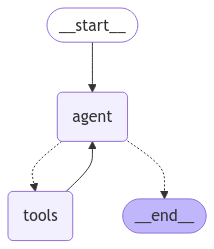

In [28]:
from IPython.display import Image, display

try :
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    pass

In [29]:
final_state = app.invoke(
    {"messages" : [HumanMessage(content="서울의 날씨는 어때?")]}
)

final_state['messages'][-1].content

'서울의 날씨는 60도(약 15도)이며 안개가 낀 상태입니다.'

In [31]:
for chunk in app.stream(
    {"messages" : [("human", "가장 추운 도시의 날씨는 어때?")]},
    stream_mode = "values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

가장 추운 도시의 날씨는 어때?
================================== Ai Message ==================================
Tool Calls:
  get_coolest_cities (call_nrK57NI3RRREQYlpc0BStjo7)
 Call ID: call_nrK57NI3RRREQYlpc0BStjo7
  Args:
================================= Tool Message =================================
Name: get_coolest_cities

서울, 고성
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_3aITF52H45yFmRRKseytGVPW)
 Call ID: call_3aITF52H45yFmRRKseytGVPW
  Args:
    location: 서울
  get_weather (call_YXdJov867sGGek3xOWCF0ayh)
 Call ID: call_YXdJov867sGGek3xOWCF0ayh
  Args:
    location: 고성
================================= Tool Message =================================
Name: get_weather

It's 90 degrees and sunny
================================== Ai Message ==================================

가장 추운 도시인 서울의 날씨는 60도(약 15도)로 안개가 끼어 있습니다. 고성의 날씨는 90도(약 32도)로 맑고 화창합

## 인터넷 검색 Tool을 결합한 에이전트

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages : Annotated[list, add_messages]

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode, tools_condition

# ToolNode -> 사용자가 정의한 Tool을 Node로 활용할 수 있도록 미리 구현해놓은 클래스
tool = TavilySearchResults(max_results=2)
tools = [tool]
tool_node = ToolNode(tools)

In [13]:
# Agent 설정
from langchain_openai import ChatOpenAI

agent = ChatOpenAI(
    model = 'gpt-4o-mini',
    temperature = 0,
)
agent_with_tools = agent.bind_tools(tools)

# Agent node 설정
def chatbot(state : State):
    response = agent_with_tools.invoke(state['messages'])
    return {"messages" : [response]}

In [14]:
# 그래프 구축
from langgraph.graph import StateGraph

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition) # tools_condition : tools를 사용할지 말지 결정하는 함수

graph_builder.set_entry_point("chatbot")

graph = graph_builder.compile()

In [ ]:
# Tool을 사용하는 질문문
graph.invoke({
    "messages" : {
        "role" : "user",
        "content" : "지금 한국 대통령은 누구야?"
    }
})

{'messages': [HumanMessage(content='지금 한국 대통령은 누구야?', additional_kwargs={}, response_metadata={}, id='d8e51d71-a424-48e9-943d-6f086b4d8bad'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wNX7w5j8rdAOBy11hAid304r', 'function': {'arguments': '{"query":"현재 한국 대통령"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 87, 'total_tokens': 108, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-6504b53a-3f0a-471f-8c49-a2626471ecbe-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '현재 한국 대통령'}, 'id': 'call_wNX7w5j8rdAOBy11hAid304r', 'type': 'tool_call'}],

In [16]:
# Tool을 사용하지 않는 질문문
graph.invoke({
    "messages" : {
        "role" : "user",
        "content" : "마이크로소프트가 어떤 회사야?"
    }
})

{'messages': [HumanMessage(content='마이크로소프트가 어떤 회사야?', additional_kwargs={}, response_metadata={}, id='221b4a8d-5e3f-4050-b0e5-5c6570abe4b6'),
  AIMessage(content='마이크로소프트(Microsoft)는 미국의 다국적 기술 회사로, 소프트웨어, 하드웨어, 전자기기 및 서비스 분야에서 활동하고 있습니다. 1975년에 빌 게이츠와 폴 앨런에 의해 설립되었으며, 본사는 워싱턴주 레드먼드에 위치하고 있습니다.\n\n마이크로소프트는 다음과 같은 주요 제품과 서비스를 제공합니다:\n\n1. **운영 체제**: Windows 시리즈는 개인용 컴퓨터와 서버에서 널리 사용되는 운영 체제입니다.\n2. **소프트웨어**: Microsoft Office 제품군(Word, Excel, PowerPoint 등)은 비즈니스 및 개인용으로 많이 사용됩니다.\n3. **클라우드 서비스**: Azure는 마이크로소프트의 클라우드 컴퓨팅 플랫폼으로, 기업들이 데이터 저장, 분석 및 애플리케이션 호스팅을 할 수 있도록 지원합니다.\n4. **하드웨어**: Surface 시리즈의 태블릿과 노트북, Xbox 게임 콘솔 등 다양한 하드웨어 제품을 제조합니다.\n5. **게임**: Xbox 게임 스튜디오와 다양한 게임 타이틀을 통해 게임 산업에서도 큰 영향력을 미치고 있습니다.\n\n마이크로소프트는 기술 혁신과 사회적 책임을 강조하며, 인공지능, 클라우드 컴퓨팅, 그리고 다양한 디지털 솔루션을 통해 전 세계적으로 많은 기업과 개인에게 서비스를 제공하고 있습니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 316, 'prompt_tokens': 89, 'total_tokens': 405, 'completion_tokens_details': {'accept

# Agent에게 기억력 부여하기

In [19]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph

from langgraph.checkpoint.memory import MemorySaver

# 인메모리 상에서 기억력이 유지되게끔 함
# 실제로 저장소를 구축하고 싶다면 -> SQLLitMemorySaver 등등 과 같은 것을 사용해야함
memory = MemorySaver()

class State(TypedDict):
    messages : Annotated[list, add_messages]

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool_node = ToolNode(tools)

model = ChatOpenAI(model="gpt-4o-mini")
model_with_tools = model.bind_tools(tools)

def agent_node(state: State):
    response = model_with_tools.invoke(state['messages'])
    return {'messages' : [response]}


graph_builder = StateGraph(State)

graph_builder.add_node("agent", agent_node)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge("tools", "agent")
graph_builder.add_conditional_edges("agent", tools_condition)

graph_builder.set_entry_point("agent")

graph = graph_builder.compile(checkpointer=memory)

In [23]:
config = {'configurable' : {"thread_id" : "1"}} # thread_id `1`에 대화가 유지되도록 설정정

while True:
    user_input = input("User : ")
    if user_input.lower() in ['quit', 'exit', 'q']:
        print("Goodbye!")
        break
    for event in graph.stream({"messages" : ("user", user_input)}, config):
        for value in event.values():
            print("Assistant : ", value['messages'][-1].content)

Assistant :  현재 대한민국의 대통령은 윤석열입니다.
Assistant :  
Assistant :  [{"url": "https://www.bbc.com/korean/articles/cge9n1r5v50o", "content": "윤석열 대통령 2차 탄핵안 14일 표결, 지난주와 상황이 달라졌다 - BBC News 코리아 윤석열 대통령 2차 탄핵 표결, 상황이 달라졌다 윤석열 대통령 '탄핵하든 수사하든 맞서겠다'2024년 12월 12일 윤 대통령 탄핵 '가결' 되면 '리더십 공백' 대안은?2024년 12월 11일 윤석열 대통령 2차 탄핵안 통과될 가능성은?2024년 12월 11일 이날 오전 12·3 비상계엄 해제 후 윤석열 대통령의 두 번째 대국민 담화가 방송돼 탄핵 표결에 영향을 줄지도 주목된다. 윤 대통령은 지난 7일 대국민 담화에서 \"저의 임기 포함해 앞으로 정국 안정 방안은 우리 당에 일임하겠다\"라며 \"향후 국정 운영은 우리 당과 정부가 함께 책임지고 해 나가겠다\"라고 밝혔다. 윤석열 대통령 2차 탄핵 표결, 상황이 달라졌다 윤 대통령 탄핵 '가결' 되면 '리더십 공백' 대안은? 윤석열 대통령 2차 탄핵 표결, 상황이 달라졌다 윤 대통령 탄핵 '가결' 되면 '리더십 공백' 대안은?"}, {"url": "https://www.bbc.com/korean/articles/cdekn42885ro", "content": "사진 설명, 윤석열 한국 대통령의 계엄령 선포는 한국인과 전 세계를 놀라게 했다 지난 2022년 근소한 차이로 당선된 윤 대통령은 지난 4월 대통령에 대한 중간평가로 여겨지는 국회의원 선거에서 패배한 이후 이미 큰 압박을 받으며 지지율 하락을 겪고 있었다. 조지워싱턴대 ‘한국 재단’ 소장인 셀레스트 애링턴 교수는 해당 총선 결과로 인해 윤 대통령은 레임덕으로 전락하며 통과된 법안에 거부권을 행사하는 식으로 밖에 영향력을 행사할 수 없었다며, 이러한 거부권 행사도 “전례 없는 빈도”로 자주 이용했다고 설명했다. 한편 이화여대 국

In [24]:
snapshot = graph.get_state(config) # 현재까지 저장된 state를 가져옴옴
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='대한민국 대통령은 누구야?', additional_kwargs={}, response_metadata={}, id='e075756f-f556-4253-a96f-440b6f90fe55'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kS1aQdAIOWXV2jm2XCEbr2av', 'function': {'arguments': '{"query":"현재 대한민국 대통령"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 86, 'total_tokens': 107, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1f45bf02-8e81-4a37-be63-0012aa2ce746-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '현재 대한민국 대통령'}, 'id': 'call_kS1aQdAIOWXV2jm2XCEbr2av', 

In [27]:
# 이전 대화가 없는 tread_id에서는 이전 대화를 가져올 수 없음음
config2 = {"configurable" : {"thread_id" : "2"}}

graph.invoke({"messages" : [
    {
        "role" : "user",
        "content" : "내가 한 첫 질문이 뭐였어?"
    }
    ]}, config2,
)

{'messages': [HumanMessage(content='내가 한 첫 질문이 뭐였어?', additional_kwargs={}, response_metadata={}, id='e970a933-4a91-43d6-8cb1-01b6facc6e54'),
  AIMessage(content='죄송하지만, 이전 대화 내용을 기억할 수 없어서 당신이 한 첫 질문을 알려드릴 수 없습니다. 하지만 새로운 질문이나 요청이 있다면 도와드릴 수 있습니다!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 89, 'total_tokens': 131, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0aa8d3e20b', 'finish_reason': 'stop', 'logprobs': None}, id='run-49ff1889-3bcf-4838-ab30-d87210fe9de7-0', usage_metadata={'input_tokens': 89, 'output_tokens': 42, 'total_tokens': 131, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

## 기억할 메시지 개수 제한하기

- 대화가 길어지면 모든 대화 내역을 답변시 반영할 수 없음
- 반영할 메시지의 수를 제한해야 함

In [35]:
def filter_messages(messages: list):
    # This is very simple helper function which only ever uses the last message
    return messages[-2:]

def agent_node(state : State):
    messages = filter_messages(state['messages'])
    result = model_with_tools.invoke(messages)
    return {"messages" : [result]}

graph_builder = StateGraph(State)

graph_builder.add_node("agent", agent_node)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge("tools", "agent")
graph_builder.add_conditional_edges("agent", tools_condition)

graph_builder.set_entry_point("agent")

graph = graph_builder.compile(checkpointer=memory)

In [36]:
from langchain_core.messages import HumanMessage

config = {"configurable" : {"thread_id" : "22"}}

input_message = HumanMessage(content="Hi! I'm bob and I like soccer")
for event in graph.stream({"messages" : [input_message]}, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

input_message = HumanMessage(content = "what's my name?")
for event in graph.stream({"messages" : [input_message]}, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

input_message = HumanMessage(content = "what's my name?")
for event in graph.stream({"messages" : [input_message]}, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

input_message = HumanMessage(content = "what's my favorite?")
for event in graph.stream({"messages" : [input_message]}, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Hi! I'm bob and I like soccer
================================== Ai Message ==================================

Hi Bob! It's great to meet you! Soccer is an exciting sport with a rich history and a huge following around the world. Do you have a favorite team or player?
================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

Your name is Bob!
================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

Your name is Bob!
================================ Human Message =================================

what's my favorite?
================================== Ai Message ==================================

I don't have access to personal information about you, so I can't kn

- 사용자 정의 함수 -> State Message 에서 특정한 값만 가져와서 사용하도록 할 수 있음
- 메시지를 모두 받아와 요약해 summary에 저장해두고 이를 llm에게 전달해 더 나은 답변을 하도록 유도할 수 있음
- 다양한 로직을 정의하고 이를 node 함수 내에 사용하면 -> 의도에 맞도록 대화 내역을 유지 할 수 있음